In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
EPS = 120
LAG = 12
STOPS=1
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
SIND = 30
DENSE = False

In [4]:
dset = SingleStop(
    SROUTE, SIND, 'train', 32, 
    lag=LAG, stops=STOPS).generator()
evalset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=LAG, stops=STOPS).generator()

Locals dataset: train (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.07s)
 [*] Has trainable inds: 109128
 [*] Subset train: 3069
 [*] Subset in Stop-30: 2129
Locals dataset: test (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.08s)
 [*] Has trainable inds: 109128
 [*] Subset test: 740
 [*] Subset in Stop-30: 540


In [5]:
from models.Conv import *
model = Conv(lag=6, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.005)
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())

Eval loss: 17.6559   


In [6]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(
            evalset, model, 
            crit=lambda y, _y: criterion(y[:, 0], _y[:, 0]).item(), result=True))
    sys.stdout.flush()
#     sch.step()

[1/120 : 66/66] - L5.95       
Eval loss: 6.0426    
[2/120 : 66/66] - L6.31       
Eval loss: 4.2412    
[3/120 : 66/66] - L2.64       
Eval loss: 3.9582   
[4/120 : 66/66] - L1.50       
Eval loss: 3.9005    
[5/120 : 66/66] - L4.70       
Eval loss: 3.8823   
[6/120 : 66/66] - L10.94      
Eval loss: 3.8765   
[7/120 : 66/66] - L3.96       
Eval loss: 3.8673    
[8/120 : 66/66] - L5.85       
Eval loss: 3.8549   
[9/120 : 66/66] - L3.15       
Eval loss: 3.8497    
[10/120 : 66/66] - L3.73       
Eval loss: 3.8426   
[11/120 : 66/66] - L1.82       
Eval loss: 3.8323   
[12/120 : 66/66] - L2.53       
Eval loss: 3.8302   
[13/120 : 66/66] - L3.64       
Eval loss: 3.8277   
[14/120 : 66/66] - L2.91       
Eval loss: 3.8157   
[15/120 : 66/66] - L3.20       
Eval loss: 3.8095    
[16/120 : 66/66] - L2.66       
Eval loss: 3.8061    
[17/120 : 66/66] - L3.19       
Eval loss: 3.8002    
[18/120 : 66/66] - L3.20       
Eval loss: 3.7954    
[19/120 : 66/66] - L6.87       
Eval loss: 3.7

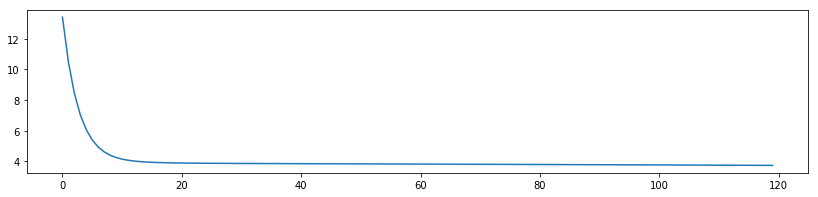

In [7]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [8]:
VIEW_LAG=96
viewdata = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=STOPS)
viewset = [viewdata[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 15
 [*] Subset in Stop-30: 1


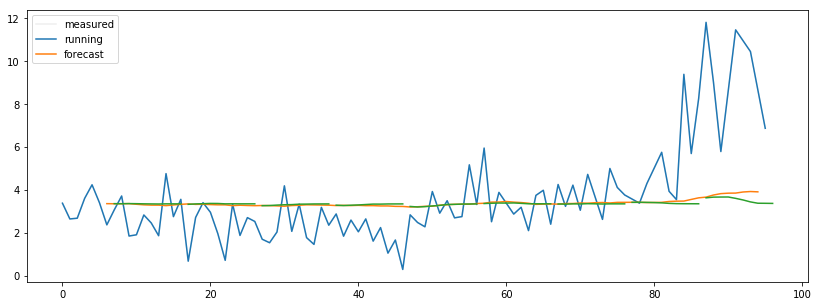

In [9]:
# TimeConv
# Spacewise first
# LR = 0.001
# STOPS = 5
show_eval(viewset, model, fmax=10, test_lag=6)
# torch.save(model.state_dict(), 'checkpoints/sconv_n5.pth')